In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.models import *
import lightgbm as lgb
import cv2
import io
import os

# Reading Data

In [2]:
listing = pd.read_csv('C:/Users/Krishi Vijayanand/Downloads/seattle/listings.csv', sep = ',')
calendars = pd.read_csv('C:/Users/Krishi Vijayanand/Downloads/seattle/calendar.csv', sep = ',')
reviews = pd.read_csv('C:/Users/Krishi Vijayanand/Downloads/seattle/reviews.csv', sep = ',')

# Seasonal Pattern of Prices

In [3]:
calendars = pd.read_csv('C:/Users/Krishi Vijayanand/Downloads/seattle/calendar.csv', sep = ',')
calendars['price'] = calendars['price'].str.replace("$","")
calendars['price']  = calendars['price'].str.replace("'","")
calendars['price'] = calendars['price'].str.replace(",","")
calendars['price'] = calendars['price'].astype('float')

In [4]:
calendars.fillna(0, inplace=True)
calendars = calendars[calendars.price != 0]

In [5]:
calendars['Year'],calendars['Month'],calendars['Day']=calendars['date'].str.split('-',2).str

<ipython-input-5-c43d87cbddb5>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  calendars['Year'],calendars['Month'],calendars['Day']=calendars['date'].str.split('-',2).str


In [6]:
monthyear = pd.DataFrame(calendars.groupby(['Year','Month']).price.mean())

In [7]:
yearDF = calendars.groupby(['Year','Month']).price.mean()
yearDF = yearDF.reset_index()
yearDF['yyyy-mm'] = yearDF['Year'] + "-" + yearDF['Month']

<AxesSubplot:xlabel='yyyy-mm'>

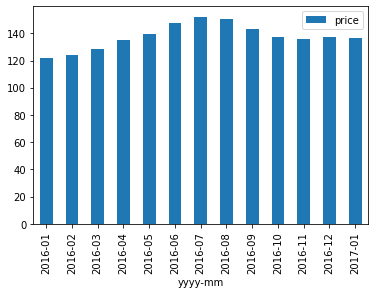

In [8]:
yearDF.plot(kind='bar', x='yyyy-mm', y='price')

It can be seen that the data is available from Jan 2016 to Jan 2017.
On analyzing, it is seen that maximum prices for listings were in the month of July.

In [9]:
from datetime import date
import datetime
import calendar
import holidays

calendars.fillna(0, inplace=True)
us_holidays = holidays.UnitedStates()

calendars['day_Name']='default'
for index,row in calendars.iterrows():
    sdate = datetime.date(int(row['Year']),int(row['Month']),int(row['Day']))
    calendars.at[index,'day_Name'] = calendar.day_name[sdate.weekday()]
calendars.to_csv('./holidays_data.csv')

<AxesSubplot:xlabel='day_Name', ylabel='price'>

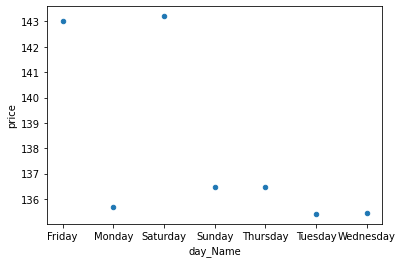

In [10]:
calendar_day = pd.DataFrame(calendars.groupby(['day_Name']).price.mean()).reset_index()
calendar_day.plot(x='day_Name',y='price', kind = 'scatter')

It can be seen that the prices are fairly high for the weekends than that of weekdays.

# Sentiment Analysis of Reviews

In [11]:
from textblob import TextBlob as tb
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [12]:
reviews['comments'] = reviews['comments'].astype('str')
def get_polarity(text):
    return tb(text).sentiment.polarity
reviews['Polarity'] = reviews['comments'].apply(get_polarity)

In [13]:
reviews['Sentiment_Type']=''
reviews.loc[reviews.Polarity>0,'Sentiment_Type']='POSITIVE'
reviews.loc[reviews.Polarity==0,'Sentiment_Type']='NEUTRAL'
reviews.loc[reviews.Polarity<0,'Sentiment_Type']='NEGATIVE'

In [14]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,Polarity,Sentiment_Type
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.433333,POSITIVE
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.301136,POSITIVE
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.410417,POSITIVE
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.358333,POSITIVE
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.493485,POSITIVE


<AxesSubplot:title={'center':'Sentiment Analysis'}>

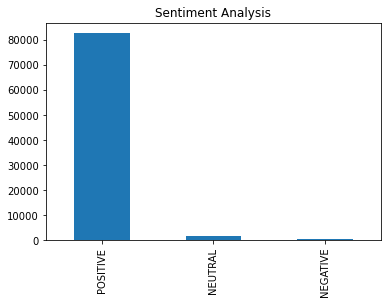

In [15]:
reviews.Sentiment_Type.value_counts().plot(kind='bar',title="Sentiment Analysis")

In [16]:
Pos = reviews.loc[reviews['Polarity'] > 0, 'Sentiment_Type'].count()
Neg = reviews.loc[reviews['Polarity'] < 0, 'Sentiment_Type'].count()
Neu = reviews.loc[reviews['Polarity'] == 0, 'Sentiment_Type'].count()
print('POSITIVE: ', Pos)
print('NEGATIVE: ', Neg)
print('NEUTRAL: ', Neu)

POSITIVE:  82757
NEGATIVE:  411
NEUTRAL:  1681


The average polarity of the first 200 listings are analysed here

<AxesSubplot:>

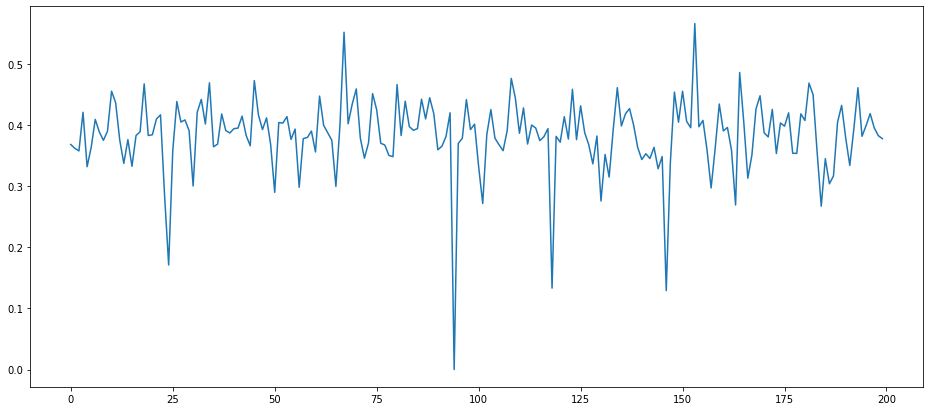

In [17]:
listing_polar = pd.DataFrame(reviews.groupby(['listing_id']).Polarity.mean()).reset_index().head(200)
listing_polar.Polarity.plot(figsize = (16,7))

Relation between number of reviews and Price is analysed

<AxesSubplot:xlabel='number_of_reviews', ylabel='price'>

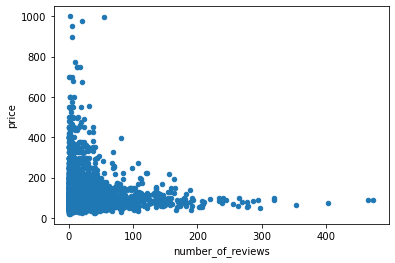

In [133]:
listing.plot(x='number_of_reviews', y='price', kind = 'scatter')

It shows that, there is no necessity for an expensive listing to have more reviews. Hence, the Prices have no relation with the Number of reviews.

# Exploratory Data Analysis for Price Prediction

Missing values in each columns

<AxesSubplot:xlabel='Feature'>

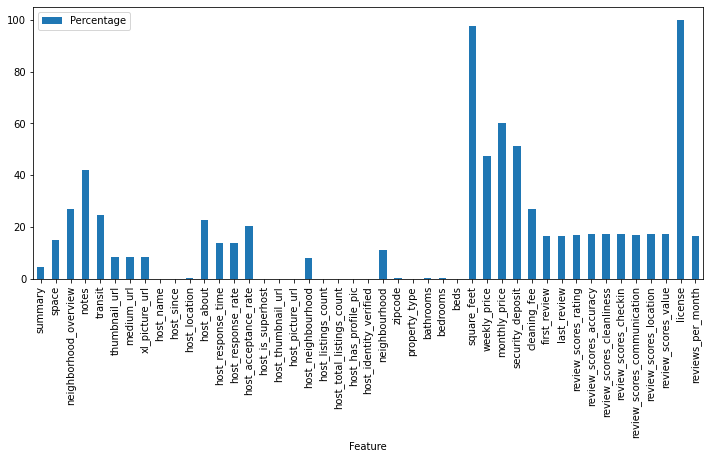

In [19]:
null_col = listing.columns[listing.isnull().sum()>0] #selecting columns with null values
per_cols = 100 - (listing[null_col].count()/len(listing)*100)
nulls_df = pd.DataFrame(per_cols,columns=['Percentage'])
nulls_df['Feature']=null_col

nulls_df.plot(x='Feature', y='Percentage', kind='bar', figsize=(12,5))

In [20]:
drop = nulls_df.loc[nulls_df['Percentage'] >20, 'Feature']

In [21]:
listing.drop(drop, axis=1, inplace=True)

# Analysing price column

In [22]:
listing['price'] = listing['price'].str.replace("$","")
listing['price']  = listing['price'].str.replace("'","")
listing['price'] = listing['price'].str.replace(",","")
listing['price'] = listing['price'].astype('float')

In [23]:
print("Skewness: %f" % listing['price'].skew())
print("Kurtosis: %f" % listing['price'].kurt())

Skewness: 3.113123
Kurtosis: 16.617132


log transformation of price column

Text(0.5, 1.0, 'Price Distribution')

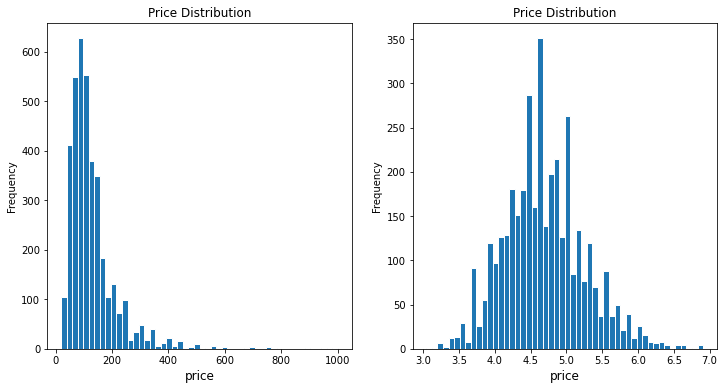

In [24]:
plt.subplot(1,2,1)
(listing['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white')
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1,2,2)
(np.log1p(listing['price'])).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white')
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [25]:
listing['log_price'] = np.log1p(listing['price']) #skewed data

# Visualizing using boxplots

Room type Vs. Price

<AxesSubplot:xlabel='room_type', ylabel='log_price'>

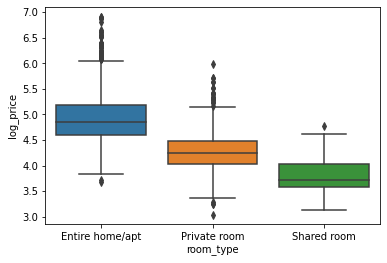

In [26]:
sns.boxplot(x = 'room_type', y = 'log_price' , data = listing)

Property Type Vs. Price

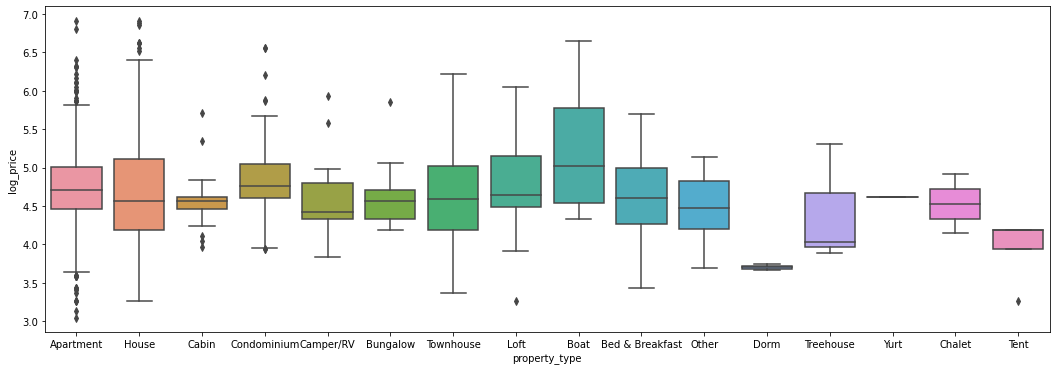

In [27]:
sns.boxplot(x = 'property_type', y = 'log_price' , data = listing )
fig = plt.gcf()
fig.set_size_inches(18,6)

Bed type Vs. Price

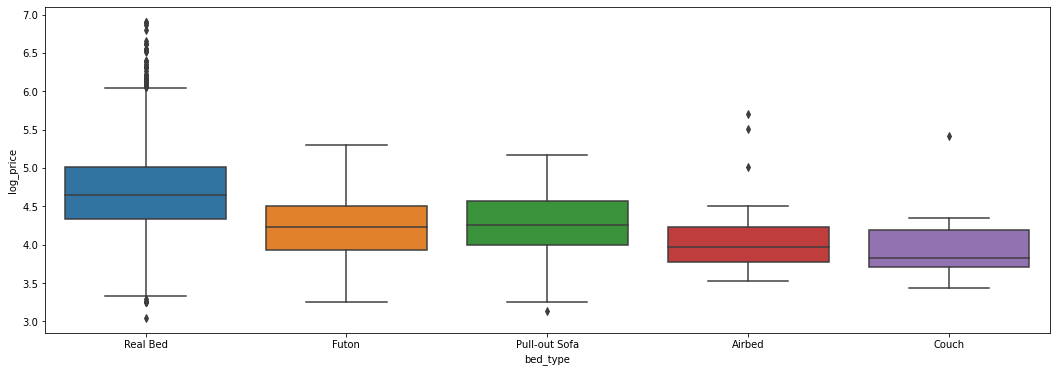

In [28]:
sns.boxplot(x = 'bed_type', y = 'log_price' , data = listing)
fig = plt.gcf()
fig.set_size_inches(18,6)

Number of bedrooms and bathrooms:

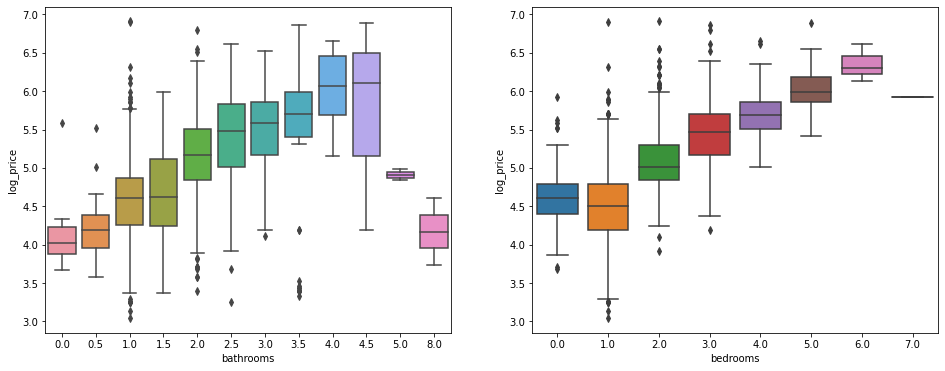

In [29]:
plt.subplot(1,2,1)
sns.boxplot(x = 'bathrooms', y = 'log_price' , data = listing)
fig = plt.gcf()
fig.set_size_inches(16,6)
plt.subplot(1,2,2)
sns.boxplot(x = 'bedrooms', y = 'log_price' , data = listing)
fig = plt.gcf()
fig.set_size_inches(16,6)

## Does being a Superhost affect the listing price?

<AxesSubplot:xlabel='host_is_superhost', ylabel='log_price'>

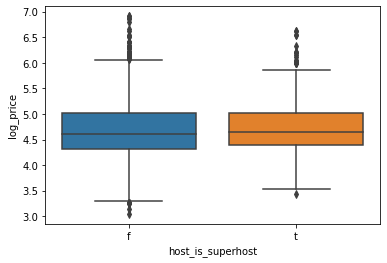

In [30]:
sns.boxplot(x = 'host_is_superhost', y = 'log_price' , data = listing)

Comparing response time 

In [31]:
listing['host_response_rate'] = listing['host_response_rate'].str.replace("%","")
listing['host_response_rate']  = listing['host_response_rate'].str.replace("'","")
listing['host_response_rate'] = listing['host_response_rate'].str.replace(",","")
listing['host_response_rate'] = listing['host_response_rate'].astype('float')

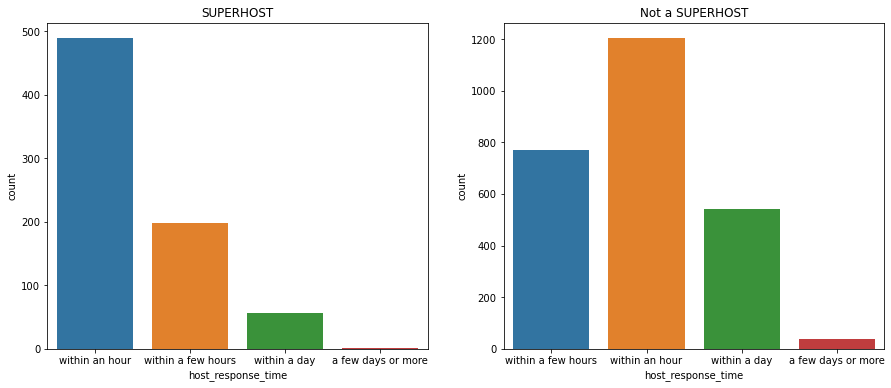

In [32]:
plt.subplot(1,2,1)
superhost = listing.loc[listing['host_is_superhost'] == 't', 'host_response_time']
sns.countplot(x=superhost).set_title("SUPERHOST")
fig = plt.gcf()
fig.set_size_inches(15,6)
plt.subplot(1,2,2)
superhost = listing.loc[listing['host_is_superhost'] == 'f', 'host_response_time']
sns.countplot(x=superhost).set_title("Not a SUPERHOST")
fig = plt.gcf()
fig.set_size_inches(15,6)

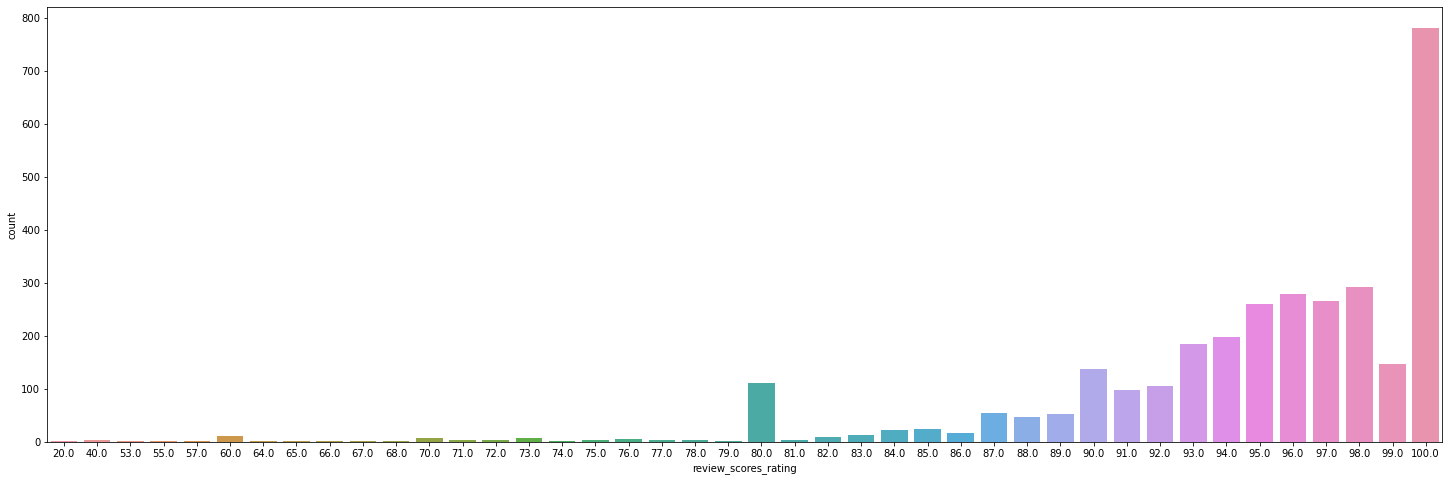

In [33]:
sns.countplot(x='review_scores_rating', data = listing)
fig = plt.gcf()
fig.set_size_inches(25,8)

# visualisations using maps

C:\Users\Krishi Vijayanand\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


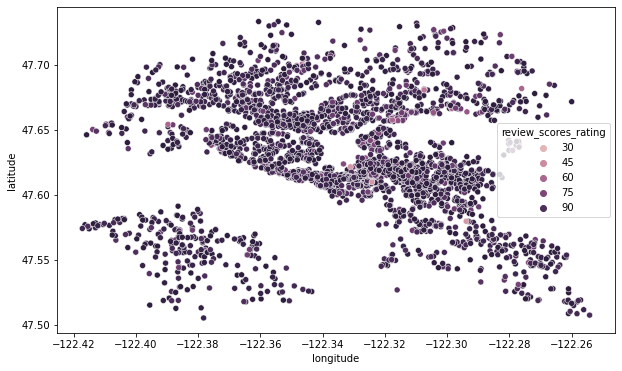

In [34]:
plt.figure(figsize=(10,6))
sns.scatterplot(listing.longitude, listing.latitude, hue = listing.review_scores_rating)
plt.ioff()

C:\Users\Krishi Vijayanand\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


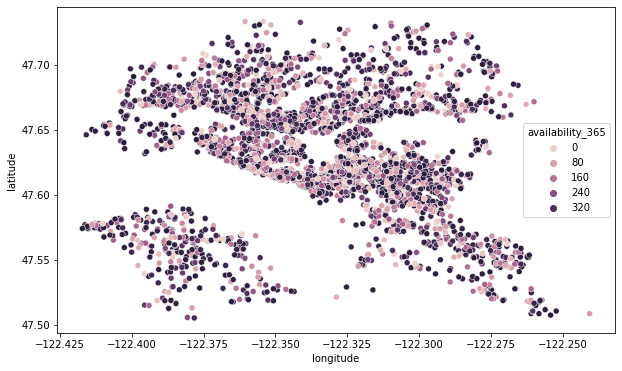

In [35]:
plt.figure(figsize=(10,6))
sns.scatterplot(listing.longitude, listing.latitude, hue = listing.availability_365)
plt.ioff()

# Correlation matrix for feature selection

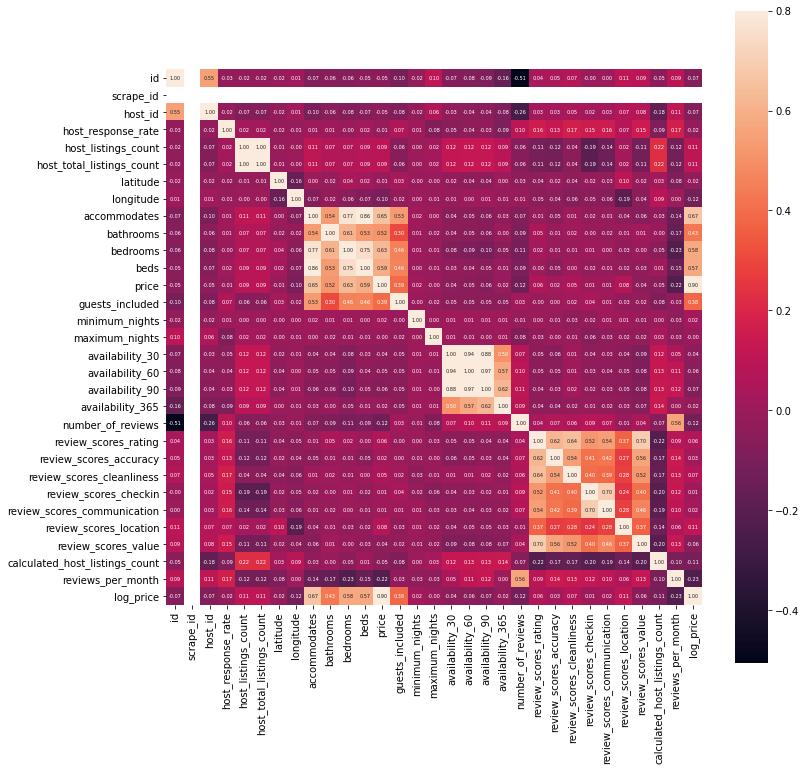

In [36]:
corrmat = listing.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 5});

# Feature Extraction for prediction

In [37]:
df = listing[['property_type', 'room_type', 'bathrooms', 'bedrooms', 'bed_type',  'accommodates', 
              'guests_included', 'neighbourhood_group_cleansed', 
              'review_scores_rating', 'log_price']]

In [38]:
df = df.drop(labels=2476, axis=0) #removing column with http error

# Data Preparation

Taking care of null data

In [39]:
df['property_type'].fillna(value='missing', inplace=True) 
df['room_type'].fillna(value='missing', inplace=True) 
df['bed_type'].fillna(value='missing', inplace=True) 
df['neighbourhood_group_cleansed'].fillna(value='missing', inplace=True)

In [40]:
df['bathrooms'].fillna(df['bathrooms'].mean(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].mean(), inplace=True)
df['review_scores_rating'].fillna(df['review_scores_rating'].mean(), inplace=True)

Encoding categorical data type

In [41]:
cols = ['property_type', 'room_type', 'bed_type', 'neighbourhood_group_cleansed']

In [42]:
data = df
oe = OrdinalEncoder()
data[cols] = oe.fit_transform(data[cols]) #cross-refer

# Reading images from URL

In [43]:
import urllib
from urllib.error import HTTPError
import skimage.io
images=[]
img_price = np.zeros((3818,1))
for i in range(3818):
    try:
        img = skimage.io.imread(listing['picture_url'][i])
        img = cv2.resize(img, (128, 128))
        images.append(img)
    except HTTPError as exception: 
        pass 

In [44]:
images = np.array(images)
images = images / 255 #scaling

# Standard Scaling Data

In [45]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [46]:
data = pd.DataFrame(data)
data.describe()

,0,1,2,3,4,5,6,7,8,9
count,3.817000e+03,3.817000e+03,3.817000e+03,3.817000e+03,3.817000e+03,3.817000e+03,3.817000e+03,3.817000e+03,3.817000e+03,3.817000e+03
mean,5.633429e-16,1.728888e-16,-1.131616e-15,-9.670895e-16,2.930442e-17,-1.454270e-15,-6.656103e-16,-7.007174e-16,-2.044183e-16,-1.062812e-16
std,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00
min,-1.065648e+00,-6.745375e-01,-2.138014e+00,-1.481606e+00,-8.231723e+00,-1.188056e+00,-1.275963e+00,-1.561430e+00,-1.238253e+01,-2.938031e+00
25%,-1.065648e+00,-6.745375e-01,-4.405536e-01,-3.487006e-01,1.886138e-01,-6.823903e-01,-5.131827e-01,-9.352941e-01,-8.929858e-02,-6.413315e-01
50%,8.812862e-01,-6.745375e-01,-4.405536e-01,-3.487006e-01,1.886138e-01,-1.767246e-01,-5.131827e-01,-3.091583e-01,7.682613e-02,-1.335207e-01
75%,8.812862e-01,1.172457e+00,-4.405536e-01,7.842047e-01,1.886138e-01,3.289410e-01,2.495971e-01,7.344014e-01,5.752003e-01,5.845879e-01
max,2.395568e+00,3.019451e+00,1.144167e+01,6.448731e+00,1.886138e-01,6.396929e+00,1.016573e+01,1.777961e+00,9.074497e-01,3.962066e+00


# Splitting Data

In [47]:
from sklearn.model_selection import train_test_split

Xatt_train, Xatt_test, Ximage_train, Ximage_test = train_test_split(data, images, test_size=0.25, random_state=42)

y_train, y_test = Xatt_train[9].values, Xatt_test[9].values

X1_train = Xatt_train[[0,1,2,3,4,5,6,7,8]].values #numerical data
X2_train = Ximage_train #images
X1_test = Xatt_test[[0,1,2,3,4,5,6,7,8]].values
X2_test = Ximage_test

print(X1_train.shape, X1_test.shape, X2_train.shape, X2_test.shape, y_train.shape, y_test.shape)

(2862, 9) (955, 9) (2862, 128, 128, 3) (955, 128, 128, 3) (2862,) (955,)


# Final model

In [50]:
def create_ann(dim, regress=False):
    model = Sequential()

    model.add(Dense(1000, input_dim=dim, activation="relu"))
    model.add(Dense(500, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(250, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(25, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(9, activation = 'linear'))
    return model

In [51]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    
    inputShape = (height, width, depth)
    chanDim = -1
    inputs = Input(shape=inputShape)
    
    conv1 = Conv2D(16, (3, 3), activation = 'relu', padding="same")(inputs)
    bn1 = BatchNormalization(axis=chanDim)(conv1)
    MaxPool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    
    conv2 = Conv2D(32, (3, 3), activation = 'relu', padding="same")(MaxPool1)
    bn2 = BatchNormalization(axis=chanDim)(conv2)
    MaxPool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
    
    conv3 = Conv2D(64, (3, 3), activation = 'relu', padding="same")(MaxPool2)
    bn3 = BatchNormalization(axis=chanDim)(conv3)
    MaxPool3 = MaxPooling2D(pool_size=(2, 2))(act3)
    
    flatten = Flatten()(MaxPool3)
    dense1 = Dense(16)(flatten)
    dense2 = Activation("relu")(dense1)
    dense3 = BatchNormalization(axis=chanDim)(dense2)
    drop = Dropout(0.5)(dense3)
    dense4 = Dense(9)(dense1,activation = 'relu')(drop)
    
    model = Model(inputs, dense4)
    
    return model

In [52]:
from tensorflow.keras.layers import concatenate
mlp = create_ann(X1_train.shape[1], regress=False)
cnn = create_cnn(128, 128, 3, regress=False)
combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(9, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

In [53]:
X1_train = np.array(X1_train)
X1_test = np.array(X1_test)
X2_test = np.array(X2_test)
X2_train = np.array(X2_train)

In [54]:
from tensorflow.keras.optimizers import Adam
model = Model(inputs=[mlp.input, cnn.input], outputs=x) #final model
opt = Adam(lr=1e-3, decay=1e-4 / 200)
model.compile(loss="mse", optimizer=opt)

print("[INFO] training model...")
model.fit(x=[X1_train, X2_train], y=y_train, validation_data=([X1_test, X2_test], y_test),epochs=10, batch_size=128)

[INFO] training model...
Epoch 1/10
23/23 [==============================] - 70s 3s/step - loss: 1.0187 - val_loss: 0.6848
Epoch 2/10
23/23 [==============================] - 62s 3s/step - loss: 0.5139 - val_loss: 0.6670
Epoch 3/10
23/23 [==============================] - 59s 3s/step - loss: 0.4249 - val_loss: 0.6749
Epoch 4/10
23/23 [==============================] - 61s 3s/step - loss: 0.3879 - val_loss: 0.6734
Epoch 5/10
23/23 [==============================] - 59s 3s/step - loss: 0.4058 - val_loss: 0.6543
Epoch 6/10
23/23 [==============================] - 48s 2s/step - loss: 0.3841 - val_loss: 0.6360
Epoch 7/10
23/23 [==============================] - 47s 2s/step - loss: 0.3316 - val_loss: 0.6252
Epoch 8/10
23/23 [==============================] - 47s 2s/step - loss: 0.3360 - val_loss: 0.6638
Epoch 9/10
23/23 [==============================] - 50s 2s/step - loss: 0.3238 - val_loss: 0.5793
Epoch 10/10
23/23 [==============================] - 47s 2s/step - loss: 0.3051 - val_loss: 0

# Testing data

From the dataset

In [250]:
X1_final = pd.DataFrame(X1_final)
print("Predicted price: ", X1_final[9].values)

Predicted price:  [4.62113062]


In [249]:
X1_final = scaler.inverse_transform(X1_final)
X1_final = pd.DataFrame(X1_final)

In [248]:
X1_final = pd.DataFrame(X1_final) #array to dataframe
X1_final[9] = y_pred #appending the price column 
X1_final = np.array(X1_final) # 1x10

In [209]:
X1_final=np.array(X1_final)
print(X1_final.shape," ",X2_final.shape)
y_pred = model.predict([np.reshape(X1_final,(1,9)),np.reshape(X2_final,(1,128,128,3))]) #MLP input and CNN input

(1, 9)   (128, 128, 3)


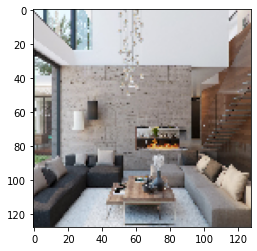

In [246]:
image_sample = skimage.io.imread('C:/Users/Krishi Vijayanand/Downloads/home.jpg')
sample_resized=cv2.resize(image_sample,(128,128))
plt.imshow(sample_resized)
X2_final = sample_resized/255 #image

In [245]:
ss = StandardScaler()
X1_final = ss.fit_transform(X1_final) #X1 shape is 1x9

In [244]:
X1_final = attr_sample

In [243]:
d = { 'property_type':[0], 
        'room_type':[0], 
        'bathrooms':[1], 
        'bedrooms':[1], 
        'bed_type':[0], 
        'accommodates':[2], 
        'guests_included':[3], 
        'neighbourhood_group_cleansed':[0], 
        'review_scores_rating':[100]}
attr_sample = pd.DataFrame(d) #dataframe created w test data

# New case

In [213]:
print("Actual price: ",attr_sample['log_price'].values)
print("Predicted price: ", X1_final[9].values)

Actual price:  [6.620073206530356]
Predicted price:  [4.62113062]


In [212]:
#attr_sample = scaler.inverse_transform(attr_sample)
#attr_sample = pd.DataFrame(attr_sample) #unscaling of specific test sample

In [211]:
X1_final = scaler.inverse_transform(X1_final)
X1_final = pd.DataFrame(X1_final) #unscaling of predicted

In [210]:
X1_final = pd.DataFrame(X1_final) #array to dataframe
X1_final[9] = y_pred #appending the price column 
X1_final = np.array(X1_final) # 1x10

In [209]:
X1_final=np.array(X1_final)
print(X1_final.shape," ",X2_final.shape)
y_pred = model.predict([np.reshape(X1_final,(1,9)),np.reshape(X2_final,(1,128,128,3))]) #MLP input and CNN input

(1, 9)   (128, 128, 3)


In [208]:
ss = StandardScaler()
X1_final = ss.fit_transform(X1_final) #X1 shape is 1x9

In [207]:
y_ground_truth=attr_sample['log_price']
X1_final= attr_sample[['property_type', 'room_type', 'bathrooms', 'bedrooms', 'bed_type',  'accommodates', 
              'guests_included', 'neighbourhood_group_cleansed', 
              'review_scores_rating']]

In [206]:
attr_sample[cols] = oe.fit_transform(attr_sample[cols])

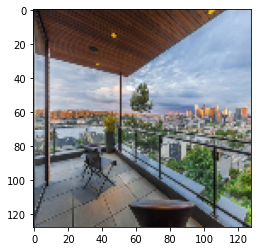

In [205]:
image_sample = skimage.io.imread(listing['picture_url'][i])
sample_resized=cv2.resize(image_sample,(128,128))
plt.imshow(sample_resized)
X2_final = sample_resized/255 #image

In [204]:
df = listing[['property_type', 'room_type', 'bathrooms', 'bedrooms', 'bed_type',  'accommodates', 
              'guests_included', 'neighbourhood_group_cleansed', 
              'review_scores_rating', 'log_price']]
i=239
attr_sample = df.iloc[i]
attr_sample = np.array(attr_sample)
attr_sample = attr_sample.reshape(1,-1)
attr_sample = pd.DataFrame(attr_sample)
attr_sample.columns = ['property_type', 'room_type', 'bathrooms', 'bedrooms', 'bed_type',  'accommodates', 
              'guests_included', 'neighbourhood_group_cleansed', 
              'review_scores_rating', 'log_price'] 
attr_sample

,property_type,room_type,bathrooms,bedrooms,bed_type,accommodates,guests_included,neighbourhood_group_cleansed,review_scores_rating,log_price
0,House,Entire home/apt,3.5,3,Real Bed,8,4,Queen Anne,100,6.62007
